# 微调--一个常用的迁移学习技术
假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出100种常见的椅子，为每种椅子拍摄1,000张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比Fashion-MNIST数据集要庞大，但样本数仍然不及ImageNet数据集中样本数的十分之一。这可能会导致适用于ImageNet数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。
## 微调的构成
微调由以下4步构成。

1. 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型。
2. 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
3. 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4. 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

## 热狗识别
实践一个具体的例子：热狗识别。我们将基于一个小数据集对在ImageNet数据集上训练好的ResNet模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。

### 获取数据集
使用的热狗数据集是从网上抓取的，它含有1400张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的1000张图像被用于训练，其余则用于测试。

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import zipfile
import wget 
import pathlib
import matplotlib.pyplot as plt
import datetime

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


In [7]:
def download_data():
    data = os.getcwd() + './data'
    base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
    wget.download(
    base_url + 'gluon/dataset/hotdog.zip',
    data)
    
    with zipfile.ZipFile('./data', 'r') as z:
        z.extranctall(os.getcwd())     

def image_data_processiong():
    train_dir = './Data/hotdog/train'
    test_dir = './Data/hotdog/test'
    train_dir = pathlib.Path(train_dir)
    train_count = len(list(train_dir.glob('*/*.jpg')))
    test_dir = pathlib.Path(test_dir)
    test_count = len(list(test_dir.glob('*/*.jpg')))
    
    CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name !='LICENSE.txt'])

    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    BATCH_SIZE = 32
    IMG_HEIGHT = 224
    IMG_WIDTH = 224
    
    train_data_gen = image_generator.flow_from_directory(directory=str(train_dir),
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    classes = list(CLASS_NAMES))

    test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    classes = list(CLASS_NAMES))
    return train_data_gen, test_data_gen, CLASS_NAMES

def show_batch(image_batch, label_batch,CLASS_NAMES):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
        
def use_FesNet50(train_data_gen, test_data_gen):
    ResNet50 = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(224,224,3))
    for layer in ResNet50.layers:
        layer.trainable = False
    net = models.Sequential()
    net.add(ResNet50)
    net.add(layers.Flatten())
    net.add(layers.Dense(2, activation = 'softmax'))
    net.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    %load_ext tensorboard
    log_dir = './log/transfer/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = net.fit_generator(
                        train_data_gen,
                        steps_per_epoch=10,
                        epochs=3,
                        validation_data=test_data_gen,
                        validation_steps=10,
                        callbacks=[tensorboard_callback]
                        )
    net.save('./ModelTrained/ResNet50_trans')
    %tensorboard --logdir log/transfer
    
    return net

def new_model(train_data_gen, test_data_gen):
    ResNet50_scratch = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224,224,3))
    net_scratch = models.Sequential()
    net_scratch.add(ResNet50_scratch)
    net_scratch.add(layers.Flatten())
    net_scratch.add(layers.Dense(2, activation='softmax'))

    net_scratch.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = net_scratch.fit_generator(
                        train_data_gen,
                        steps_per_epoch=10,
                        epochs=3,
                        validation_data=test_data_gen,
                        validation_steps=10
                        )
    return net.scratch 


Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
10/10 [==============================] - 5s 548ms/step - loss: 0.6661 - accuracy: 0.8188 - val_loss: 0.6619 - val_accuracy: 0.8406
Epoch 2/3
10/10 [==============================] - 6s 567ms/step - loss: 0.6596 - accuracy: 0.8224 - val_loss: 0.6576 - val_accuracy: 0.8438
Epoch 3/3
10/10 [==============================] - 5s 465ms/step - loss: 0.6541 - accuracy: 0.8844 - val_loss: 0.6502 - val_accuracy: 0.8594
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./ModelTrained/ResNet50_trans\assets


Reusing TensorBoard on port 6006 (pid 7920), started 0:46:31 ago. (Use '!kill 7920' to kill it.)

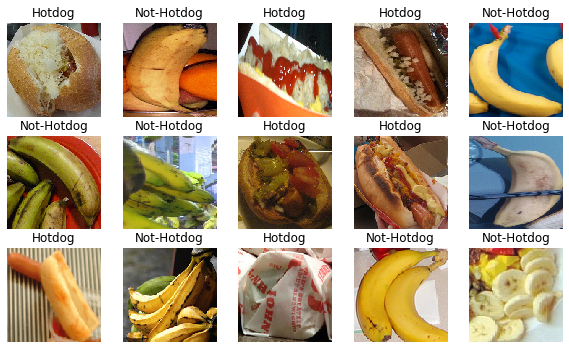

In [12]:
if __name__ == '__main__':
    train_data_gen, test_data_gen, CLASS_NAMES = image_data_processiong()
    image_batch, label_batch = next(train_data_gen)
    show_batch(image_batch, label_batch,CLASS_NAMES)
    use_FesNet50(train_data_gen, test_data_gen)